<a href="https://colab.research.google.com/github/bukyt/MachineLearningProject/blob/master/Kodu7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Kodu 7 - Pildifailist teksti tuvastamine ja sellest lühikokkuvõtte tegemine

Ülesande kirjeldus enne tööga alustamist: Kasutaja annab sisendina ette pildifaili. Pildilt tuvastatakse mõne pilditöötlusmudeliga tekst, millest tehakse keelemudeli abil (nt bert-extractive-summarizer teek)  abil n-lauseline lühikokkuvõte, n annab kasutaja sisendina ette. Püüame saada asja tööle eestikeelsetel tekstidel kasutades EstBert mudelit (kui pole võimalik, teeme ingliskeelsetel tekstidel).  
Viited:  
https://github.com/dmmiller612/bert-extractive-summarizer  
https://medium.com/analytics-vidhya/text-summarization-using-bert-gpt2-xlnet-5ee80608e961

## 1. Etteantud pildilt Tesseract abil teksti tuvastamine

In [ ]:
#Improdid
# Colabi jaoks vajalikud impordid
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/")

!pip install pytesseract
!sudo apt install tesseract-ocr

# Colabis vajalik teek piltide näitamiseks
from google.colab.patches import cv2_imshow
import cv2 as cv
from PIL import Image
import pytesseract

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Enne jätkamist lae alla [eesti keele tuvastusmudel](https://github.com/tesseract-ocr/tessdata/blob/main/est.traineddata) ja lae see üles oma drive-i colab kausta (nagu varasemates praksides olnud lisafailid)
ning testimiseks lae pilt/kuvatõmmis tekstist üles drive-i

In [ ]:
# Eesti keele mudeli asukoht eeldusel, et laadisid üles Colab kausta
%env TESSDATA_PREFIX=/content/drive/MyDrive/Colab Notebooks

env: TESSDATA_PREFIX=/content/drive/MyDrive/Colab Notebooks


In [ ]:
#Sisend testimiseks
path_to_image="näidis.png"

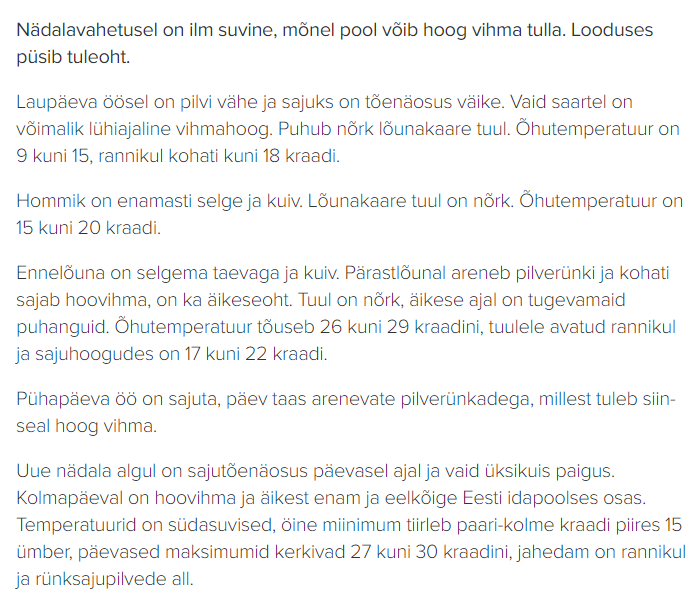

In [ ]:
cv2_imshow(cv.imread(path_to_image))

In [ ]:
#pildilt teksti tuvastamine

extracted_information = pytesseract.image_to_string(Image.open(path_to_image), lang="est")
print(extracted_information)

Nädalavahetusel on ilm suvine, mõnel pool võib hoog vihma tulla. Looduses
püsib tuleoht.

  

Laupäeva öösel on pilvi vähe ja sajuks on tõenäosus väike. Vaid saartel on
võimalik lühiajaline vihmahoog. Puhub nõrk lõunakaare tuul. Õhutemperatuur on
9 kuni 15, rannikul kohati kuni 18 kraadi.

Hommik on enamasti selge ja kuiv. Lõunakaare tuul on nõrk. Õhutemperatuur on
15 kuni 20 kraadi.

Ennelõuna on selgema taevaga ja kuiv. Pärastlõunal areneb pilverünki ja kohati
sajab hoovihma, on ka äikeseoht. Tuul on nõrk, äikese ajal on tugevamaid
puhanguid. Õhutemperatuur tõuseb 26 kuni 29 kraadini, tuulele avatud rannikul
ja sajuhoogudes on 17 kuni 22 kraadi.

Pühapäeva öö on sajuta, päev taas arenevate pilverünkadega, millest tuleb siin-
seal hoog vihma.

Uue nädala algul on sajutõenäosus päevasel ajal ja vaid üksikuis paigus.
Kolmapäeval on hoovihma ja äikest enam ja eelkõige Eesti idapoolses osas.
Temperatuurid on südasuvised, öine miinimum tiirleb paari-kolme kraadi piires 15
ümber, päevased m

# 2. Kokkuvõtte tegemine tuvastatud tekstist

In [ ]:
#impordid eraldi sest ebamugav on iga kord mahukaid pilditöötluse teeke laadida kui tahame ainult keeletöötlusega tegeleda
!pip install estnltk
!pip install sentence-transformers
import numpy as np
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
from estnltk import Text
from sentence_transformers import SentenceTransformer, models, InputExample, losses
import logging
from sklearn.metrics.pairwise import cosine_similarity

Üldjoontes on kaks lähenemist kokkuvõtte tegemiseks

1. 'Extractive Text Summarization'

Mis tähendab et võtame teatud hulga olulisemaid lauseid tekstist välja mingi algoritmi alusel, nt kõikide lausete klastritesse jagamine ja igast klastrist kõige esinduslikuma valimine. See on lihtsam ja rohkem levinud lähenemine, laused on täpselt samad nagu algses tekstis.

2. 'Abstractive Text Summarization'

Siin enam pole mitte algse teksti laused, vaid genereeritakse teksti sisu põhjal täiesti uued laused, mis võtavad teksti kokku. Selleks kasutatakse reeglina keerukaid närvivõrke, mis on treenitud suurel hulgal tekstiandmetel ja mille ülesanne on mõisa sõnade ja lausete vahelisi seoseid. Samas, kuna masinõppemudel loob nullist uue teksti, siis siin on võimalus, et ta kirjutab midagi, mida algses tekstis ei olnud, hallutsioneerib, vms.

Allikas: https://www.analyticsvidhya.com/blog/2023/03/exploring-the-extractive-method-of-text-summarization/

Meie valisime neist esimese extractive summarization, sest seda me saame ise implementeerida, 2. abstractive summarization oleks tähendanud lihtsalt valmiskujul vastava mudeli kasutamist (mida me ei leidnud, et eestikeelset oleks olemas? inglise keeles nt distilbart-cnn-12-6 ja palju muid selliseks ülesandeks sobivaid mudeleid), sest ise me nii keerukat mudelit nullist ei ole võimelised looma?, eeldab suurt hulka sobivaid andmeid ja arvutusressurssi et ta universaalselt kõigil tekstidel töötaks ja mõistaks kõigi tekstide lausete tähendusi.

Kõige pealt on vaja pildifailist eraldatud tekst teha lauseteks, et töötleme eestikeelseid tekste, kasutame selleks Estnltk

In [ ]:
#Estnltk abil teksti lauseteks jagamine
def split_text_into_sentences(text):
    t = Text(text)
    t.tag_layer(['sentences'])
    sentences = t['sentences']
    sentence_list = [' '.join([word.text for word in sentence.words]) for sentence in sentences]
    #print(sentence_list)
    return sentence_list


Lausete võrdlemiseks ja sarnasuse mõõtmiseks vajame nende embeddinguid, selleks kasutame Estbert mudelit, mille abil saame sõnade embeddingud ja arvutada lausete embeddingud.

Kasutame mean-pooling lauseembeddingute saamiseks, idee ja koodilõigud https://www.geeksforgeeks.org/how-to-generate-word-embedding-using-bert/

BERT (and other transformer networks) output for each token in our input text an embedding. In order to create a fixed-sized sentence embedding out of this, the model applies mean pooling, i.e., the output embeddings for all tokens are averaged to yield a fixed-sized vector.

Seda lähenemist peetakse töötavaks, aga mitte parimaks "Reminding that BERT pre-train was trained by MaskedLM, NextSentencePrediction, hence the original purpose of BERT is not to create a meaningful embedding of the sentence but for some specific downstream task." https://peaceful0907.medium.com/sentence-embedding-by-bert-and-sentence-similarity-759f7beccbf1


In [ ]:
#lausete embeddingute leidmine Estbert abil
# lähenemise kuidas saada word embeddings põhjal lause omad võtsime siit https://www.geeksforgeeks.org/how-to-generate-word-embedding-using-bert/

def get_sentence_embeddings_mean_pooling(sentences):

    #et väljundist kõiksugu hoiatused ära saada
    logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

    #kasutame EstBERTi
    model_name = 'tartuNLP/EstBERT'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        #computes the mean of the last hidden state along the sequence dimension (dim=1) to get a single vector representing the sentence. This vector is detached from the computation graph and converted to a NumPy array.
        embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy())


    return embeddings


Proovime alternatiivina ka vastavaks ülesandeks loodud mudeli abil lause embeddingute leidmist, mis võiks paremaid embeddinguid tagastada


https://www.sbert.net/docs/quickstart.html#
Kasutame multilingual mudelit distiluse-base-multilingual-cased-v2, mis dokumentatsiooni järgi sobib ka eesti keelele, samas ei ole väidetavalt kõige parem
"The following models generate aligned vector spaces, i.e., similar inputs in different languages are mapped close in vector space. You do not need to specify the input language"
https://www.sbert.net/docs/pretrained_models.html#multi-lingual-models
Ainult eesti keelele loodud mudelit ei leidnud, mis võiks veelgi paremini hakkama saada

In [ ]:


def get_sentence_embeddings_sentenceTransformer(sentences):

    #et väljundid liigset infot ei sisaldaks
    logging.getLogger("sentence_transformers").setLevel(logging.ERROR)

    #  laeme SentenceTransformer mudeli
    model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

    embeddings=[]
    # leiame mudeliga lausete embeddingud
    for sentence in sentences:
        embeddings.append([model.encode(sentence)])


    return embeddings


### Kokkuvõttesse lausete valimine

Algoritme, kuidas valida embeddingute põhjal välja lauseid kokkuvõttesse, on mitu. Implementeerime neist kahte.

1) Järjestame lausete embeddingud selle põhjal, kui sarnased need on kogu tekstiga (kõigi lausete embeddingute keskmine) ja valime neist välja n esimest. https://www.kdnuggets.com/2019/01/approaches-text-summarization-overview.html

2) Jagame laused n klastrisse nt k_means algoritmiga ja võtame igast klastrist kõige esinduslikuma. Nii paistab töötavat nt see valmisteek (mis Estbert ja eesti keelt ei toeta) extractive summarization jaoks https://github.com/dmmiller612/bert-extractive-summarizer

In [ ]:
# 1) kõige sarnasemte lausete valimine


def get_summary(embeddings, num_sentences, sentences):
  # leiame lausete embeddingute keskmise ehk embeddingu, mis võiks vastata kogu tekstile
  text_embedding = np.mean(embeddings, axis=0)
  #käime läbi kõikide lausete embeddingute listi, leiame iga lause embeddingu ja kogu teksti embeddingu vahelise cosine similarity
  #loomuliku keele töötluses embeddingute puhul on just cosine similarity kõige levinum/parem viis kahe sõnavtori vahelise kauguse/sarnasuse leidmiseks https://medium.com/@techclaw/cosine-similarity-between-two-arrays-for-word-embeddings-c8c1c98811b
  similarities = [cosine_similarity(emb, text_embedding) for emb in embeddings]

  # järjestame laused sarnasuse alusel ja valime esimesed num_sentences ehk kõige sarnasemad
  ranked_sentences = [sent for _, sent in sorted(zip(similarities, sentences), key=lambda x: x[0], reverse=True)]
  summary = ''.join(ranked_sentences[:num_sentences])

  return summary



def summarize_similarity_mean_pooling(text, summary_length):
    # Tekst lausete listiks
    sentences = split_text_into_sentences(text)

     # Iga lause embedding
    embeddings = get_sentence_embeddings_mean_pooling(sentences)

    return get_summary(embeddings, summary_length, sentences)


def summarize_similarity_sentenceTransformer(text, summary_length):
    # Tekst lausete listiks
    sentences = split_text_into_sentences(text)

     # Iga lause embedding
    embeddings = get_sentence_embeddings_sentenceTransformer(sentences)
    return get_summary(embeddings, summary_length, sentences)

In [ ]:
# 2) klasterdamine

def k_means_clustering(embeddings, num_clusters):
    embeddings = np.vstack(embeddings)  # Muudame embeddinute loendi NumPy massiiviks
    #jagame embeddingut num_clusters arvu klastritesse
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
    kmeans.fit(embeddings)
    #print(kmeans.labels_)  # Prindib välja, millisesse klastrisse laused kuuluvad
    return kmeans.labels_, kmeans.cluster_centers_

def summarize_cluster(embeddings, summary_length, sentences):

    # Klasterdamine, tagastab labels listi, kus on igale lausele vastav klastri number samas järjekorras nagu laused ette anti, teeme nii mitu klastrit, kui mitut lauset kokkuvõttesse tahame, cluster_centers on iga klastri keskpunkt
    labels, cluster_centers = k_means_clustering(embeddings, summary_length)

    #print(cluster_centers)

#et vaadata, kuidas algoritm klastritesse jagab, kommenteeri järgmised read välja
#    for i in range(len(sentences)):
#        print("Klastrisse " + str(labels[i]) + " määrati lause " + sentences[i])

    # Kokkuvõtte tegemiseks võtame klastrite kõige esinduslikumad laused, iga klastri kõige esinduslikum võiks olla see, mis on kõige rohkem keskel (seda kasutavad ka teised summarizerid)
    summary = []
    for i in range(summary_length):
        #võtame välja need embeddingud mis kuuluvad samasse klastrisse
        cluster_indices = np.where(labels == i)[0]
        # paneme vastava klastri embeddingud ühte numpy arraysse
        cluster_embeddings = np.vstack([embeddings[j] for j in cluster_indices])
        #leiame selle klastri keskpunkti, keskpunktid tagastas k_means_clustering
        centroid = cluster_centers[i]
        #leiame iga lause embeddingu kauguse klastris keskpunktist
        distances = [np.linalg.norm(embedding - centroid) for embedding in cluster_embeddings]
        #leiame lähima lause embeddingu keskpunktile
        closest_index = cluster_indices[np.argmin(distances)]
        #leiame sellele vastava lause
        closest_sentence = sentences[closest_index]
        summary.append(closest_sentence)

    return ''.join(summary)


def summarize_cluster_mean_pooling(text, summary_length):
    # Tekst lausete listiks
    sentences = split_text_into_sentences(text)
     # Iga lause embedding
    embeddings = get_sentence_embeddings_mean_pooling(sentences)
    return summarize_cluster(embeddings, summary_length, sentences)

def summarize_cluster_sentenceTransformer(text, summary_length):
    # Tekst lausete listiks
    sentences = split_text_into_sentences(text)
     # Iga lause embedding
    embeddings = get_sentence_embeddings_sentenceTransformer(sentences)
    return summarize_cluster(embeddings, summary_length, sentences)



### Testimine ja võrdlemine

In [ ]:

text = """
Kuidas saab automaatselt tuvastada, kas pildi peal olev inimene on Jaak Vilo? Millised algoritmid juhivad tolmuimeja roboteid ja isesõitvaid autosid? Kas arvuti suudab mängida "7 minutes in heaven" inimestest paremini?

Kursuse eesmärk on tutvuda tehisintellektiga ning mõnede selle valdkonna harudega nagu masinõpe, loomuliku keele töötlus, pilditöötlus jt. Tutvuda saab nii teoreetilise küljega (probleemid, lahendused, algoritmid) kui ka praktiliselt, lahendades tehisintellekti ülesandeid praktikumides ning kodutöö jooksul.

Siit Moodle'st leiate loengute, prakside ja kodutööde materjale, ning siin saab vastata loengujärgsetele küsimustele, esitada koduülesannete ning eksami lahendusi ja vaadata oma hindeid. Muu info kursuse kohta on ÕISis.
"""

num_sent = 3

# sarnasus kogu tekstiga mean pooling embeddingud
summary = summarize_similarity_mean_pooling(text, num_sent)

print("\n Sarnasus kogu tekstiga algoritm mean pooling embeddingud: ")
print(summary)

# sarnasus kogu tekstiga sentenceTransformer embeddingud
summary = summarize_similarity_sentenceTransformer(text, num_sent)

print("\n Sarnasus kogu tekstiga algoritm sentenceTransformer embeddingud: ")
print(summary)

print("\n Klasterdamisalgoritm mean pooling embeddingud: ")

#klasterdamine mean pooling
summary = summarize_cluster_mean_pooling(text, num_sent)
print(summary)

print("\n Klasterdamisalgoritm sentenceTransformer embeddingud: ")

#klasterdamine sentenceTransformer
summary = summarize_cluster_sentenceTransformer(text, num_sent)
print(summary)




 Sarnasus kogu tekstiga algoritm mean pooling embeddingud: 
Tutvuda saab nii teoreetilise küljega ( probleemid , lahendused , algoritmid ) kui ka praktiliselt , lahendades tehisintellekti ülesandeid praktikumides ning kodutöö jooksul . 
Kursuse eesmärk on tutvuda tehisintellektiga ning mõnede selle valdkonna harudega nagu masinõpe , loomuliku keele töötlus , pilditöötlus jt. 
Siit Moodle'st leiate loengute , prakside ja kodutööde materjale , ning siin saab vastata loengujärgsetele küsimustele , esitada koduülesannete ning eksami lahendusi ja vaadata oma hindeid .

 Sarnasus kogu tekstiga algoritm sentenceTransformer embeddingud: 
Millised algoritmid juhivad tolmuimeja roboteid ja isesõitvaid autosid ? 
Tutvuda saab nii teoreetilise küljega ( probleemid , lahendused , algoritmid ) kui ka praktiliselt , lahendades tehisintellekti ülesandeid praktikumides ning kodutöö jooksul . 
Kuidas saab automaatselt tuvastada , kas pildi peal olev inimene on Jaak Vilo ?

 Klasterdamisalgoritm mean po

In [ ]:
text = """
Eesti otsusele toetada 10. mail ÜRO Peaassambleel resolutsiooni, mis tõstab Palestiina vaatlejariigi positsiooni maailmaorganisatsioonis ning kutsub talle pakkuma täisliikme staatust, eelnes peaministri ja välisministri põhjalik suhtlus Põhjamaade ja Balti riikide esindajatega.
"Eesti suursaadik ÜRO juures hääletas nii, nagu seda nägi ette Vabariigi Valitsuse otsus," ütles ERR-ile Carlos Kleimann valitsuse kommunikatsioonibüroost.
Enne hääletuse toimumist suhtles peaminister Kaja Kallas (Reformierakond) sel teemal Läti, Leedu, Soome, Rootsi ja Norra peaministritega.
ERR küsis, kas Kallas soovitas nendel riigijuhtidel hääletusel poolt hääletada.
"On tavapärane, et koordineerime ja tutvustame seisukohti oma lähimate partneritega. Mõistagi on nii meile kui ka teistele riikidele oluline Põhja-Balti regiooni ühtsus, nii on loomulikuks sihiks ühisele positsioonile jõudmine. Selles valguses tutvustas ka peaminister Eesti kaalutlusi mitmele kolleegile. On hea tava ja austus partnerite vastu seda suhtlust avalikkuses mitte avaldada," vastas Kleimann.
Kleimann rääkis, et Eesti tegi läbimõeldud otsuse.
"Muutunud on geopoliitiline olukord meie ümber –  Eesti julgeolekule on kasvavalt oluline, et sõda Lähis-Idas ei eskaleeruks veelgi enam ja et Iisraeli-Palestiina konfliktile leitaks lahendus. Meile on eksistentsiaalselt oluline, et muude konfliktide varjus ei saaks Venemaa oma agressiooni Ukraina vastu tugevdada. Niisama tähtis on see, et globaalne toetus Ukrainale kasvaks ja et meid ei oleks põhjust süüdistada topeltstandardites, ega selles, et me oleme keskendunud Ukraina toetamisele. Selleks ühines Eesti 142 ÜRO liikmesriigiga ja saatis signaali, et Lähis-Ida poliitilist protsessi tuleb tagant tõugata ning sellega tuleb kiirelt edasi liikuda," loetles Kleimann.
"Eesti on pikaaegselt toetanud seda, et Palestiina saaks oma riigi ehk toetame kahe riigi lahendust Lähis-Ida konfliktis. Resolutsioonist ei tulene Palestiina tunnustamine. Palestiina tunnustamine on eraldiseisev protsess, milleks on vaja Vabariigi Valitsuse otsust," lisas ta.
Eesti hääletas 10. mail New Yorgis peetud ÜRO Peaassambleel resolutsiooni poolt, mis tõstab Palestiina vaatlejariigi positsiooni maailmaorganisatsioonis ning kutsub talle pakkuma täisliikme staatust.
Euroopa Liit läks hääletusel pooleks: 14 riiki toetasid resolutsiooni, 11 jäi erapooletuks ja kaks olid vastu. Ungari ja Tšehhi - hääletasid selle vastu. Eestiga sarnaselt hääletasid resolutsiooni poolt Belgia, Küpros, Taani, Prantsusmaa, Kreeka, Iirimaa, Luksemburg, Poola, Portugal, Slovakkia, Sloveenia, Hispaania ja Malta. Eesti lähinaabrid Läti, Leedu, Soome ja Rootsi jäid erapooletuks.

Endine välisminister, opositsioonilise erakonna Isamaa esimees Urmas Reinsalu nägi Eesti otsuses olulist muutust Eesti välispoliitikas.
Reinsalu ütles, et varasemalt välisministrina andis ta välisministeeriumis selge juhise, et kui EL-i riikide seisukohad on selles valdkonnas ÜRO-s lõhki, siis Eesti ei hääleta USA seisukoha vastu.
Reeglina on Eesti välispoliitiline liin olnud selline, et Eesti hääletas ÜRO hääletustel koos Euroopa Liiduga, aga kui Euroopa Liit on antud küsimuses pooleks, siis hääletab Eesti koos USA-ga või jääb erapooletuks.
Ka SDE-sse kuuluv endine välisminister ja diplomaat, eurosaadik Marina Kaljurand (SDE) ütles, et Eesti tegi hääletusega oma senises poliitikas muutuse ning tema oleks hoidnud senist joont.
"Ilmselt minu soovitus oleks olnud jätkata vana poliitikaga, aga kui see niimoodi tehti, siis ma ei näe selles katastroofi," ütles Kaljurand ERR-i uudisteportaali "Otse uudistemajast" erisaates.
"Ma ei näe selles väga suurt probleemi. Jah, Eesti välispoliitika on olnud selline, et toetame Euroopa Liitu, kui Euroopa Liit on lõhki, siis hääletame nii nagu Ameerika Ühendriigid. Praegu on tehtud väike nihe, suur nihe oleks siis, kui me oleks praegu koos kolme riigiga tunnustanud Palestiina riiki," lisas Kaljurand.

"""

# sarnasus kogu tekstiga mean pooling embeddingud
summary = summarize_similarity_mean_pooling(text, num_sent)

print("\n Sarnasus kogu tekstiga algoritm mean pooling embeddingud: ")
print(summary)

# sarnasus kogu tekstiga sentenceTransformer embeddingud
summary = summarize_similarity_sentenceTransformer(text, num_sent)

print("\n Sarnasus kogu tekstiga algoritm sentenceTransformer embeddingud: ")
print(summary)

print("\n Klasterdamisalgoritm mean pooling embeddingud: ")

#klasterdamine mean pooling
summary = summarize_cluster_mean_pooling(text, num_sent)
print(summary)

print("\n Klasterdamisalgoritm sentenceTransformer embeddingud: ")

#klasterdamine sentenceTransformer
summary = summarize_cluster_sentenceTransformer(text, num_sent)
print(summary)


 Sarnasus kogu tekstiga algoritm mean pooling embeddingud: 
Reinsalu ütles , et varasemalt välisministrina andis ta välisministeeriumis selge juhise , et kui EL-i riikide seisukohad on selles valdkonnas ÜRO-s lõhki , siis Eesti ei hääleta USA seisukoha vastu . 
Selleks ühines Eesti 142 ÜRO liikmesriigiga ja saatis signaali , et Lähis-Ida poliitilist protsessi tuleb tagant tõugata ning sellega tuleb kiirelt edasi liikuda , " loetles Kleimann . 
Reeglina on Eesti välispoliitiline liin olnud selline , et Eesti hääletas ÜRO hääletustel koos Euroopa Liiduga , aga kui Euroopa Liit on antud küsimuses pooleks , siis hääletab Eesti koos USA-ga või jääb erapooletuks .

 Sarnasus kogu tekstiga algoritm sentenceTransformer embeddingud: 
Reeglina on Eesti välispoliitiline liin olnud selline , et Eesti hääletas ÜRO hääletustel koos Euroopa Liiduga , aga kui Euroopa Liit on antud küsimuses pooleks , siis hääletab Eesti koos USA-ga või jääb erapooletuks . 
Jah , Eesti välispoliitika on olnud selline 

## 3. funktsioon, mis teeb mõlemat

In [ ]:
def image_to_summary(path_to_img, number_of_sentences, algorithm, embeddings):
    #tuvastame pildilt teksti
    extracted_information = pytesseract.image_to_string(Image.open(path_to_img), lang="est")
    if algorithm=="cluster" and embeddings=="pooling":
        return summarize_cluster_mean_pooling(extracted_information, number_of_sentences)
    if algorithm=="cluster" and embeddings=="sentenceTransformer":
        return summarize_cluster_sentenceTransformer(extracted_information, number_of_sentences)
    if algorithm=="top_sentences" and embeddings=="pooling":
        return summarize_similarity_mean_pooling(extracted_information, number_of_sentences)
    if algorithm=="top_sentences" and embeddings=="sentenceTransformer":
        return summarize_similarity_sentenceTransformer(extracted_information, number_of_sentences)



In [ ]:
image_to_summary("näidis.png", 3, "top_sentences", "pooling" )

'Pühapäeva öö on sajuta , päev taas arenevate pilverünkadega , millest tuleb siin- seal hoog vihma .Uue nädala algul on sajutõenäosus päevasel ajal ja vaid üksikuis paigus .Tuul on nõrk , äikese ajal on tugevamaid puhanguid .'

In [ ]:
image_to_summary("näidis.png", 3, "top_sentences", "sentenceTransformer" )

'Laupäeva öösel on pilvi vähe ja sajuks on tõenäosus väike .Lõunakaare tuul on nõrk .Pühapäeva öö on sajuta , päev taas arenevate pilverünkadega , millest tuleb siin- seal hoog vihma .'

In [ ]:
image_to_summary("näidis.png", 3, "cluster", "pooling" )

'Pühapäeva öö on sajuta , päev taas arenevate pilverünkadega , millest tuleb siin- seal hoog vihma .Õhutemperatuur tõuseb 26 kuni 29 kraadini , tuulele avatud rannikul ja sajuhoogudes on 17 kuni 22 kraadi .Lõunakaare tuul on nõrk .'

In [ ]:
image_to_summary("näidis.png", 3, "cluster", "sentenceTransformer" )

'Pühapäeva öö on sajuta , päev taas arenevate pilverünkadega , millest tuleb siin- seal hoog vihma .Puhub nõrk lõunakaare tuul .Õhutemperatuur on 9 kuni 15 , rannikul kohati kuni 18 kraadi .'